<a href="https://colab.research.google.com/github/Bhuvana2488/airl-cv/blob/main/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch, torchvision, sys, os
print("PyTorch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch: 2.8.0+cu126
Device: cuda


In [4]:
import math, time
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

In [5]:
# Config - tweak to search for best model
cfg = {
    "img_size": 32,
    "patch_size": 4,      # 32 / 4 = 8 -> 8x8 patches -> 64 patches
    "in_chans": 3,
    "embed_dim": 256,     # model width
    "depth": 8,           # number of transformer blocks
    "num_heads": 8,
    "mlp_ratio": 4.0,
    "dropout": 0.1,
    "num_classes": 10,
    "batch_size": 128,
    "epochs": 80,
    "lr": 3e-4,
    "weight_decay": 0.05,
    "device": device,
    "save_path": "best_vit_cifar10.pth"
}

torch.manual_seed(42)
np.random.seed(42)

In [6]:
# CIFAR-10 stats
mean = (0.4914, 0.4822, 0.4465)
std = (0.247, 0.243, 0.261)

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # Try enabling RandAugment if you want stronger augmentation:
    # transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:03<00:00, 46.3MB/s]


In [7]:
# Vision Transformer implementation (compact, readable)
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=256):
        super().__init__()
        assert img_size % patch_size == 0
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        # Use multihead attention (batch_first=True so we work with (B, N, dim))
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: (B, N, dim)
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm, need_weights=False)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=256, depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Positional embedding for patches + cls
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        # Head for classification
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize positional embedding
        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        # x: (B, C, H, W)
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)

        # Append CLS token
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (B, num_patches + 1, embed_dim)

        # Add positional embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Norm and take CLS token's output
        x = self.norm(x)
        return x[:, 0] # (B, embed_dim)

    def forward(self, x):
        x = self.forward_features(x) # (B, embed_dim)
        x = self.head(x) # (B, num_classes)
        return x

In [8]:
# Training utilities
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k / batch_size).item()*100.0)
        return res

def validate(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    losses = 0.0
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            losses += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += images.size(0)
            correct += (preds == targets).sum().item()
    return correct / total * 100.0, losses / total

In [9]:
# Train function (mixed precision)
def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    pbar = tqdm(loader)
    loss_fn = nn.CrossEntropyLoss()
    running_loss = 0.0
    running_acc = 0.0
    total = 0
    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # stats
        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        running_acc += (outputs.argmax(dim=1) == targets).sum().item()
        total += batch_size
        pbar.set_description(f"loss: {running_loss/total:.4f}, acc: {running_acc/total*100:.2f}")
    return running_loss/total, running_acc/total*100.0

# Setup optimizer & scheduler
model = VisionTransformer(**{k: v for k, v in cfg.items() if k not in ['batch_size', 'epochs', 'lr', 'weight_decay', 'device', 'save_path']}).to(cfg["device"])
optimizer = optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
# simple cosine annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["epochs"])
scaler = GradScaler()

/tmp/ipython-input-3602301511.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
best_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_acc": [], "val_loss": []}
for epoch in range(cfg["epochs"]):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, cfg["device"])
    val_acc, val_loss = validate(model, test_loader, cfg["device"])
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model_state": model.state_dict(), "cfg": cfg, "epoch": epoch, "best_acc": best_acc}, cfg["save_path"])

    print(f"Epoch {epoch+1}/{cfg['epochs']}  train_loss={train_loss:.4f} train_acc={train_acc:.2f}  val_loss={val_loss:.4f} val_acc={val_acc:.2f}  time={time.time()-t0:.1f}s  best={best_acc:.2f}")

  0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-3602301511.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss: 1.7625, acc: 34.01: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s]


Epoch 1/80  train_loss=1.7625 train_acc=34.01  val_loss=1.5311 val_acc=43.25  time=36.6s  best=43.25


loss: 1.4450, acc: 47.15: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]


Epoch 2/80  train_loss=1.4450 train_acc=47.15  val_loss=1.3297 val_acc=51.11  time=33.8s  best=51.11


loss: 1.2964, acc: 52.92: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s]


Epoch 3/80  train_loss=1.2964 train_acc=52.92  val_loss=1.2258 val_acc=55.85  time=33.6s  best=55.85


loss: 1.2007, acc: 56.56: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]


Epoch 4/80  train_loss=1.2007 train_acc=56.56  val_loss=1.1136 val_acc=59.99  time=33.4s  best=59.99


loss: 1.1319, acc: 59.26: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]


Epoch 5/80  train_loss=1.1319 train_acc=59.26  val_loss=1.0509 val_acc=61.88  time=33.6s  best=61.88


loss: 1.0714, acc: 61.47: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]


Epoch 6/80  train_loss=1.0714 train_acc=61.47  val_loss=1.0104 val_acc=64.11  time=33.3s  best=64.11


loss: 1.0301, acc: 62.99: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]


Epoch 7/80  train_loss=1.0301 train_acc=62.99  val_loss=0.9668 val_acc=65.73  time=33.2s  best=65.73


loss: 0.9803, acc: 65.00: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]


Epoch 8/80  train_loss=0.9803 train_acc=65.00  val_loss=0.9154 val_acc=67.25  time=33.0s  best=67.25


loss: 0.9405, acc: 66.51: 100%|██████████| 391/391 [00:29<00:00, 13.08it/s]


Epoch 9/80  train_loss=0.9405 train_acc=66.51  val_loss=0.9062 val_acc=68.57  time=33.6s  best=68.57


loss: 0.9055, acc: 67.90: 100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch 10/80  train_loss=0.9055 train_acc=67.90  val_loss=0.8464 val_acc=69.58  time=34.3s  best=69.58


loss: 0.8637, acc: 69.28: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch 11/80  train_loss=0.8637 train_acc=69.28  val_loss=0.8503 val_acc=70.04  time=34.1s  best=70.04


loss: 0.8376, acc: 70.15: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]


Epoch 12/80  train_loss=0.8376 train_acc=70.15  val_loss=0.8143 val_acc=71.22  time=33.9s  best=71.22


loss: 0.8077, acc: 71.25: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]


Epoch 13/80  train_loss=0.8077 train_acc=71.25  val_loss=0.7727 val_acc=72.42  time=33.3s  best=72.42


loss: 0.7789, acc: 72.50: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s]


Epoch 14/80  train_loss=0.7789 train_acc=72.50  val_loss=0.7877 val_acc=72.24  time=33.7s  best=72.42


loss: 0.7486, acc: 73.50: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]


Epoch 15/80  train_loss=0.7486 train_acc=73.50  val_loss=0.7577 val_acc=73.18  time=33.5s  best=73.18


loss: 0.7238, acc: 74.27: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]


Epoch 16/80  train_loss=0.7238 train_acc=74.27  val_loss=0.7559 val_acc=73.13  time=33.3s  best=73.18


loss: 0.7061, acc: 75.14: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]


Epoch 17/80  train_loss=0.7061 train_acc=75.14  val_loss=0.7048 val_acc=75.72  time=33.3s  best=75.72


loss: 0.6777, acc: 76.05: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s]


Epoch 18/80  train_loss=0.6777 train_acc=76.05  val_loss=0.7128 val_acc=74.98  time=32.8s  best=75.72


loss: 0.6564, acc: 76.83: 100%|██████████| 391/391 [00:29<00:00, 13.03it/s]


Epoch 19/80  train_loss=0.6564 train_acc=76.83  val_loss=0.7085 val_acc=75.28  time=33.6s  best=75.72


loss: 0.6393, acc: 77.39: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]


Epoch 20/80  train_loss=0.6393 train_acc=77.39  val_loss=0.6766 val_acc=76.61  time=33.3s  best=76.61


loss: 0.6200, acc: 78.12: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]


Epoch 21/80  train_loss=0.6200 train_acc=78.12  val_loss=0.6559 val_acc=77.41  time=32.9s  best=77.41


loss: 0.6020, acc: 78.65: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]


Epoch 22/80  train_loss=0.6020 train_acc=78.65  val_loss=0.6598 val_acc=77.12  time=33.4s  best=77.41


loss: 0.5777, acc: 79.55: 100%|██████████| 391/391 [00:30<00:00, 13.01it/s]


Epoch 23/80  train_loss=0.5777 train_acc=79.55  val_loss=0.6292 val_acc=78.02  time=33.7s  best=78.02


loss: 0.5613, acc: 80.20: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch 24/80  train_loss=0.5613 train_acc=80.20  val_loss=0.6366 val_acc=78.21  time=34.5s  best=78.21


loss: 0.5496, acc: 80.54: 100%|██████████| 391/391 [00:31<00:00, 12.58it/s]


Epoch 25/80  train_loss=0.5496 train_acc=80.54  val_loss=0.6169 val_acc=78.73  time=34.9s  best=78.73


loss: 0.5303, acc: 81.12: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s]


Epoch 26/80  train_loss=0.5303 train_acc=81.12  val_loss=0.6016 val_acc=79.25  time=33.1s  best=79.25


loss: 0.5136, acc: 81.84: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s]


Epoch 27/80  train_loss=0.5136 train_acc=81.84  val_loss=0.6438 val_acc=78.39  time=33.5s  best=79.25


loss: 0.4990, acc: 82.44: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]


Epoch 28/80  train_loss=0.4990 train_acc=82.44  val_loss=0.6121 val_acc=79.24  time=33.3s  best=79.25


loss: 0.4833, acc: 82.74: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]


Epoch 29/80  train_loss=0.4833 train_acc=82.74  val_loss=0.6239 val_acc=79.22  time=33.1s  best=79.25


loss: 0.4627, acc: 83.42: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


Epoch 30/80  train_loss=0.4627 train_acc=83.42  val_loss=0.6052 val_acc=79.61  time=34.6s  best=79.61


loss: 0.4512, acc: 84.02: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]


Epoch 31/80  train_loss=0.4512 train_acc=84.02  val_loss=0.6092 val_acc=79.77  time=33.5s  best=79.77


loss: 0.4338, acc: 84.50: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]


Epoch 32/80  train_loss=0.4338 train_acc=84.50  val_loss=0.6223 val_acc=79.87  time=33.5s  best=79.87


loss: 0.4214, acc: 84.92: 100%|██████████| 391/391 [00:30<00:00, 12.95it/s]


Epoch 33/80  train_loss=0.4214 train_acc=84.92  val_loss=0.5721 val_acc=80.93  time=34.0s  best=80.93


loss: 0.4005, acc: 85.69: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]


Epoch 34/80  train_loss=0.4005 train_acc=85.69  val_loss=0.5761 val_acc=81.27  time=33.2s  best=81.27


loss: 0.3871, acc: 86.14: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


Epoch 35/80  train_loss=0.3871 train_acc=86.14  val_loss=0.6018 val_acc=80.51  time=33.6s  best=81.27


loss: 0.3744, acc: 86.44: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]


Epoch 36/80  train_loss=0.3744 train_acc=86.44  val_loss=0.5817 val_acc=81.04  time=33.6s  best=81.27


loss: 0.3590, acc: 87.31: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]


Epoch 37/80  train_loss=0.3590 train_acc=87.31  val_loss=0.5887 val_acc=81.17  time=34.4s  best=81.27


loss: 0.3414, acc: 87.77: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch 38/80  train_loss=0.3414 train_acc=87.77  val_loss=0.5816 val_acc=82.08  time=34.0s  best=82.08


loss: 0.3283, acc: 88.23: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s]


Epoch 39/80  train_loss=0.3283 train_acc=88.23  val_loss=0.6043 val_acc=81.57  time=33.8s  best=82.08


loss: 0.3113, acc: 88.71: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]


Epoch 40/80  train_loss=0.3113 train_acc=88.71  val_loss=0.5920 val_acc=81.80  time=33.2s  best=82.08


loss: 0.3006, acc: 89.26: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]


Epoch 41/80  train_loss=0.3006 train_acc=89.26  val_loss=0.5913 val_acc=81.57  time=33.8s  best=82.08


loss: 0.2900, acc: 89.43: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]


Epoch 42/80  train_loss=0.2900 train_acc=89.43  val_loss=0.6019 val_acc=81.72  time=33.8s  best=82.08


loss: 0.2752, acc: 90.05: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch 43/80  train_loss=0.2752 train_acc=90.05  val_loss=0.6072 val_acc=81.90  time=34.0s  best=82.08


loss: 0.2629, acc: 90.60: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


Epoch 44/80  train_loss=0.2629 train_acc=90.60  val_loss=0.5922 val_acc=82.29  time=33.8s  best=82.29


loss: 0.2509, acc: 91.08: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]


Epoch 45/80  train_loss=0.2509 train_acc=91.08  val_loss=0.6005 val_acc=82.21  time=33.4s  best=82.29


loss: 0.2372, acc: 91.51: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s]


Epoch 46/80  train_loss=0.2372 train_acc=91.51  val_loss=0.6088 val_acc=82.11  time=33.6s  best=82.29


loss: 0.2314, acc: 91.64: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]


Epoch 47/80  train_loss=0.2314 train_acc=91.64  val_loss=0.6537 val_acc=81.38  time=33.5s  best=82.29


loss: 0.2151, acc: 92.32: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]


Epoch 48/80  train_loss=0.2151 train_acc=92.32  val_loss=0.6189 val_acc=82.36  time=33.1s  best=82.36


loss: 0.2037, acc: 92.77: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch 49/80  train_loss=0.2037 train_acc=92.77  val_loss=0.6329 val_acc=82.62  time=34.3s  best=82.62


loss: 0.1910, acc: 93.25: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch 50/80  train_loss=0.1910 train_acc=93.25  val_loss=0.6377 val_acc=82.27  time=34.6s  best=82.62


loss: 0.1825, acc: 93.48: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]


Epoch 51/80  train_loss=0.1825 train_acc=93.48  val_loss=0.6428 val_acc=82.26  time=33.4s  best=82.62


loss: 0.1732, acc: 93.80: 100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch 52/80  train_loss=0.1732 train_acc=93.80  val_loss=0.6602 val_acc=82.58  time=34.1s  best=82.62


loss: 0.1610, acc: 94.18: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]


Epoch 53/80  train_loss=0.1610 train_acc=94.18  val_loss=0.6592 val_acc=82.54  time=33.4s  best=82.62


loss: 0.1551, acc: 94.39: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]


Epoch 54/80  train_loss=0.1551 train_acc=94.39  val_loss=0.6933 val_acc=82.51  time=33.3s  best=82.62


loss: 0.1443, acc: 94.79: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


Epoch 55/80  train_loss=0.1443 train_acc=94.79  val_loss=0.6960 val_acc=81.96  time=33.9s  best=82.62


loss: 0.1399, acc: 94.94: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]


Epoch 56/80  train_loss=0.1399 train_acc=94.94  val_loss=0.6965 val_acc=82.62  time=33.5s  best=82.62


loss: 0.1320, acc: 95.29: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


Epoch 57/80  train_loss=0.1320 train_acc=95.29  val_loss=0.7006 val_acc=82.60  time=34.5s  best=82.62


loss: 0.1229, acc: 95.58: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]


Epoch 58/80  train_loss=0.1229 train_acc=95.58  val_loss=0.7262 val_acc=82.24  time=33.6s  best=82.62


loss: 0.1148, acc: 95.90: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]


Epoch 59/80  train_loss=0.1148 train_acc=95.90  val_loss=0.7150 val_acc=82.62  time=33.2s  best=82.62


loss: 0.1133, acc: 95.94: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch 60/80  train_loss=0.1133 train_acc=95.94  val_loss=0.7254 val_acc=82.22  time=34.0s  best=82.62


loss: 0.1033, acc: 96.26: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]


Epoch 61/80  train_loss=0.1033 train_acc=96.26  val_loss=0.7358 val_acc=82.56  time=33.4s  best=82.62


loss: 0.1029, acc: 96.24: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]


Epoch 62/80  train_loss=0.1029 train_acc=96.24  val_loss=0.7291 val_acc=82.44  time=33.2s  best=82.62


loss: 0.0933, acc: 96.68: 100%|██████████| 391/391 [00:31<00:00, 12.60it/s]


Epoch 63/80  train_loss=0.0933 train_acc=96.68  val_loss=0.7543 val_acc=82.69  time=34.8s  best=82.69


loss: 0.0907, acc: 96.74: 100%|██████████| 391/391 [00:29<00:00, 13.24it/s]


Epoch 64/80  train_loss=0.0907 train_acc=96.74  val_loss=0.7522 val_acc=82.61  time=33.1s  best=82.69


loss: 0.0860, acc: 96.93: 100%|██████████| 391/391 [00:30<00:00, 13.01it/s]


Epoch 65/80  train_loss=0.0860 train_acc=96.93  val_loss=0.7512 val_acc=82.81  time=33.7s  best=82.81


loss: 0.0832, acc: 97.08: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]


Epoch 66/80  train_loss=0.0832 train_acc=97.08  val_loss=0.7479 val_acc=82.98  time=33.8s  best=82.98


loss: 0.0789, acc: 97.24: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]


Epoch 67/80  train_loss=0.0789 train_acc=97.24  val_loss=0.7663 val_acc=82.99  time=33.2s  best=82.99


loss: 0.0738, acc: 97.38: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


Epoch 68/80  train_loss=0.0738 train_acc=97.38  val_loss=0.7763 val_acc=82.74  time=33.9s  best=82.99


loss: 0.0717, acc: 97.47: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]


Epoch 69/80  train_loss=0.0717 train_acc=97.47  val_loss=0.7762 val_acc=82.77  time=33.6s  best=82.99


loss: 0.0648, acc: 97.67: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch 70/80  train_loss=0.0648 train_acc=97.67  val_loss=0.7869 val_acc=82.89  time=34.2s  best=82.99


loss: 0.0666, acc: 97.64: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s]


Epoch 71/80  train_loss=0.0666 train_acc=97.64  val_loss=0.7784 val_acc=82.96  time=33.8s  best=82.99


loss: 0.0626, acc: 97.80: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]


Epoch 72/80  train_loss=0.0626 train_acc=97.80  val_loss=0.7836 val_acc=83.10  time=33.4s  best=83.10


loss: 0.0586, acc: 97.95: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]


Epoch 73/80  train_loss=0.0586 train_acc=97.95  val_loss=0.7919 val_acc=83.16  time=33.2s  best=83.16


loss: 0.0606, acc: 97.91: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s]


Epoch 74/80  train_loss=0.0606 train_acc=97.91  val_loss=0.7923 val_acc=83.04  time=33.9s  best=83.16


loss: 0.0579, acc: 97.96: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]


Epoch 75/80  train_loss=0.0579 train_acc=97.96  val_loss=0.7922 val_acc=83.14  time=33.1s  best=83.16


loss: 0.0590, acc: 97.93: 100%|██████████| 391/391 [00:30<00:00, 13.01it/s]


Epoch 76/80  train_loss=0.0590 train_acc=97.93  val_loss=0.7924 val_acc=83.23  time=34.0s  best=83.23


loss: 0.0564, acc: 98.03: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]


Epoch 77/80  train_loss=0.0564 train_acc=98.03  val_loss=0.7950 val_acc=83.24  time=33.8s  best=83.24


loss: 0.0577, acc: 97.96: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]


Epoch 78/80  train_loss=0.0577 train_acc=97.96  val_loss=0.7923 val_acc=83.33  time=33.1s  best=83.33


loss: 0.0576, acc: 97.98: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch 79/80  train_loss=0.0576 train_acc=97.98  val_loss=0.7939 val_acc=83.26  time=34.0s  best=83.33


loss: 0.0545, acc: 98.12: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]


Epoch 80/80  train_loss=0.0545 train_acc=98.12  val_loss=0.7938 val_acc=83.28  time=33.3s  best=83.33


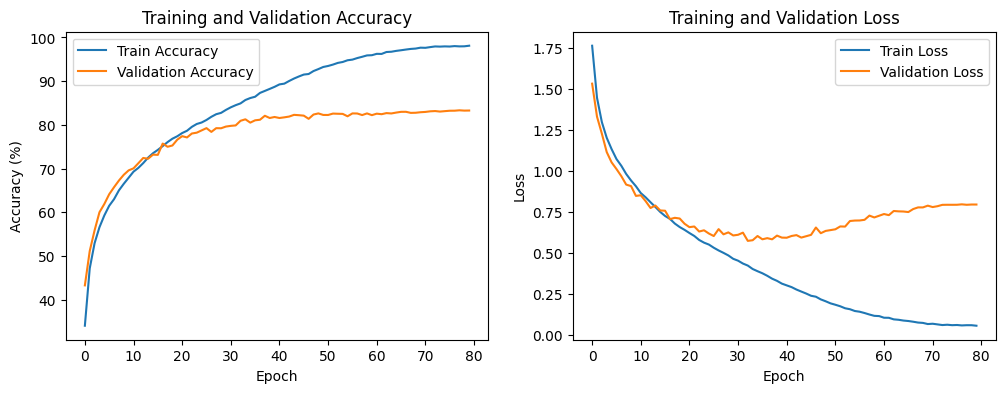

In [11]:
# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()